In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.constants as c
import copy

import tinyarray as ta
from pescado import poisson
from pescado.mesher import shapes, patterns, voronoi

from qpc_exp2sim.simulation.QPC_geometry import qpc
from qpc_exp2sim.pescado_kwant.extension_pes import cross_section, reflect #, add_kwant_system
from qpc_exp2sim.simulation import builder
from qpc_exp2sim.pescado_kwant import pescado_kwant, extension_pes, plotting_pes

Shape version: 0.2


In [2]:
def gates_shape(W_reg, L_narrow_gate, qpc_center, qpc_name, d_contact, d_up, 
                **kwargs):    
    # Create the upper narrow gate by using a rectangular (Box) shape
    narrow_gate_up = shapes.Box(lower_left=[qpc_center[0]-L_narrow_gate/2, 
                                            qpc_center[1], d_up-d_contact], 
                                size=[L_narrow_gate, W_reg/2 - qpc_center[1], 
                                      d_contact])
    
    # Create the quantum point contact by using an circle (Ellipsoid)
    qpc_shape = qpc(qpc_name, 
                center = qpc_center, 
                interval=[d_up-d_contact, d_up])
    
    # The full upper gate is the union of gate_up, narrow_gate_up, and qpc
    gate_up_shape = narrow_gate_up | qpc_shape
    
    # Use 2 reflections to define the down gate
    gate_down_shape = reflect(gate_up_shape, [0,0,0], [1,0,0])
    gate_down_shape = reflect(gate_down_shape, [0,0,0], [0,1,0])
    
    shape = gate_up_shape | gate_down_shape

    return shape


def layer0_shape(L_reg, W_reg, d0, d_2DEG, **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, -d_2DEG/2 - d0], 
                      size=[L_reg, W_reg, d0])
    return shape

    
def DEG_shape(L_reg, W_reg, d_2DEG, **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, -d_2DEG/2], 
                      size=[L_reg, W_reg, d_2DEG])
    return shape
    
def layer1_shape(L_reg, W_reg, d_2DEG, d1, **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, d_2DEG/2], 
                      size=[L_reg, W_reg, d1])
    return shape
   
def layer2_shape(L_reg, W_reg, d_2DEG, d1, d2, **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, d_2DEG/2+d1], 
                      size=[L_reg, W_reg, d2])
    return shape
   
def layer3_shape(L_reg, W_reg, d_2DEG, d1, d2, d3, **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, d_2DEG/2+d1+d2], 
                      size=[L_reg, W_reg, d3])
    return shape
    

def layer4_shape(L_reg, W_reg, d_2DEG, d1, d2, d3, d4, **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, d_2DEG/2+d1+d2+d3], 
                      size=[L_reg, W_reg, d4])
    return shape


def air(L_reg, W_reg, L_narrow_gate, qpc_center, qpc_name, d_contact, d_up, 
        **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, d_up - d_contact], 
                      size=[L_reg, W_reg, d_contact]) - \
            gates_shape(W_reg, L_narrow_gate, qpc_center, qpc_name, d_contact, 
                        d_up)
    return shape


def device_shape(L_pes, W_pes, d0, d_2DEG, d_tot, **kwargs):
    # define using bbox
    shape = shapes.Box(lower_left=[-L_pes/2, -W_pes/2, -d_2DEG/2 - d0], 
                      size=[L_pes, W_pes, d_tot])
    return shape


def device_reg_shape(L_pes, W_pes, L_reg, W_reg, d0, d_2DEG, d_tot, **kwargs):
    shape = shapes.Box(lower_left=[-L_reg/2, -W_reg/2, -d_2DEG/2 - d0], 
                       size=[L_reg, W_reg, d_tot]) -\
            device_shape(L_pes, W_pes, d0, d_2DEG, d_tot)
    return shape


def mesh_points(interfaces, zones, w, size):
    """
    Parameters
    ----------
    
    interfaces: np.ndarray of floats
        Location where the interfaces have to be
    
    zones : np.ndarray of bools
        Specify whether there can be only a single point (True) in the zone or more (False).
        No correct result is given when single point zones with different sizes are next to each other.
        The zones next to a single point zone should have mathematically at least half of the 
        size of the single point zone but a larger margin is recommended.
    
    w : float
        Number that specifies the distance between to voronoi points around an interface
        if the voronoi points around the interface can be chosen freely (no limitations
        from single point zones). 
        e.g.:
                    point       interface     point
                      x             |           x
                      <-------------------------> = w
    size : float
        size of a voronoi cell (guideline, not strictly respected)
        
    Returns
    -------
    mesh_points : np.ndarray
        Location of the necessary mesh points that respect the interfaces
        
    info : np.ndarray
        In column 0: a reference point
        In column 1: the periodicity
    """
    # w en size moeten kleiner zijn dan de helft van de kleinste multi point zone
    zone_size = np.diff(interfaces)
    assert np.all(zone_size[np.logical_not(zones)] >= max(w*2, size*2)), \
    'w & min_size need to be smaller than half the size of the smallest multi point zone'
    
    # De zones naast een single point zone moeten minstens 0.6 keer zo groot zijn als de single point zone
    # Dit om inbalans te vermijden
    # 2 single point zones met verschillende grootte mogen niet naast elkaar liggen
    
    mesh_points = np.array([])
    info = np.empty((len(zones), 2))
    
    # First handle the zones in which there may only be one mesh point
    single_point_zones = np.where(zones)[0]
    for zone in single_point_zones:
        dx = interfaces[zone+1] - interfaces[zone]
        if zone == 0:
            new_points = np.array([interfaces[zone] + dx/2, 
                                   interfaces[zone+1] + dx/2])
        elif zone == len(zones)-1:
            new_points = np.array([interfaces[zone] -dx/2, 
                                   interfaces[zone] + dx/2])
        else:        
            new_points = np.array([interfaces[zone] -dx/2, 
                                   interfaces[zone] + dx/2, 
                                   interfaces[zone+1] + dx/2])
        mesh_points = np.append(mesh_points, new_points)
        info[zone] = np.array([interfaces[zone] + dx/2, dx])
        
    # Unique is necessary since several single point zones with the same size 
    # may be laying next to each other
    mesh_points = np.unique(mesh_points)
    
    # Add mesh points around the other interfaces
    multi_point_zones = np.where(np.logical_not(zones))[0]
    
    for zone in set(multi_point_zones) - {0}:
        if zone - 1 in multi_point_zones:
            new_points = np.array([interfaces[zone] - w/2, 
                                   interfaces[zone] + w/2])
            mesh_points = np.append(mesh_points, new_points)
    
    mesh_points = np.sort(mesh_points)
    mesh_points2 = mesh_points
        
    # Fill the multi point zones up
    for zone in set(multi_point_zones):
        zone_boundaries = [interfaces[zone], interfaces[zone+1]]
        
        limitation_l = np.where(np.all([interfaces[zone] < mesh_points, 
                                        mesh_points<interfaces[zone+1] - zone_size[zone]/2], axis=0))[0]
        limitation_r = np.where(np.all([interfaces[zone] + zone_size[zone]/2 < mesh_points, 
                                        mesh_points<interfaces[zone+1]], axis=0))[0]    

        
        boundary_l = max(np.hstack([mesh_points[limitation_l], zone_boundaries[0]]))
        boundary_r = min(np.hstack([mesh_points[limitation_r], zone_boundaries[1]]))
        
        # Distance between the 2 mesh points bounding the zone
        d = boundary_r - boundary_l
        
        # Number of points that should be added
        n = int(d/size) - 1
        
        if n == 0:
            if d > size:
                spacing = (boundary_r - boundary_l)/2
                new_points = np.array([boundary_l + spacing])
            else:
                spacing = boundary_r - boundary_l
                new_points = np.array([])
        elif n == 1:
            spacing = (boundary_r - boundary_l)/2
            new_points = np.array([boundary_l + spacing])
        else:
            spacing = d/(n+1)
            new_points = np.arange(boundary_l+spacing, boundary_r, spacing)
        
        mesh_points2 = np.append(mesh_points2, new_points)
        
        ref_point = boundary_l if zone != 0 else boundary_r
        info[zone] = np.array([ref_point, spacing])
    
    return (np.sort(mesh_points2), info)


def simplify_zones(info):
    zone = 0
    zone_tracker = [[zone] for zone in range(len(info))]
    while zone < len(info)-1:
        if info[zone, 1] == info[zone + 1, 1]:
            info = np.delete(info, zone+1, axis=0)
            zone_tracker[zone].append(zone_tracker[zone+1][0])
            del zone_tracker[zone+1]
        else:
            zone += 1
    return info, zone_tracker


def _union_box_shapes(shapes_list):
    """ Union of box shapes, returns a single box
    """
    total_bbox = shapes.add_bbox([shape.bbox for shape in shapes_list])
    size = np.diff(total_bbox, axis=0)[0]
    return shapes.Box(lower_left = total_bbox[0], 
                      size = size)


def union(shapes_list, index):
    """Union of a list of shapes
    
    shapes_list : sequence of shapes
        The shape on the last position may be another Union instance, 
        The shape on the other positions should be of type shapes.Box
        and should only differ in one dimension.
    
    index : list, np.ndarray
        The indices of the shapes in the list for which the union has to be made
    """
    # The gates have the only special shape, they are treated separately
    if len(shapes_list) - 1 in index:
        return _union_box_shapes(np.asarray(shapes_list)[index][:-1]) | shapes_list[-1]
    else:
        return _union_box_shapes(np.asarray(shapes_list)[index])


def make_pescado_system(grid_fine, L_pes, W_pes, L_narrow_gate, qpc_center, 
                        qpc_name, d0, d_2DEG, 
                        d1, d2, d3, d4, d_contact, d_up, d_tot, eps_GaAs, 
                        eps_AlGaAs, eps_air, eps_gates, calibration_device,
                        zones, w, size, **kwargs):
    
    pp_builder = poisson.PoissonProblemBuilder()
    
    # Defining the several shape objects relevant for the problem
    layer0 = layer0_shape(L_pes, W_pes, d0, d_2DEG)
    layer1 = layer1_shape(L_pes, W_pes, d_2DEG, d1)
    layer2 = layer2_shape(L_pes, W_pes, d_2DEG, d1, d2)
    layer3 = layer3_shape(L_pes, W_pes, d_2DEG, d1, d2, d3)
    layer4 = layer4_shape(L_pes, W_pes, d_2DEG, d1, d2, d3, d4)

    DEG = DEG_shape(L_pes, W_pes, d_2DEG)
    gates = gates_shape(W_pes, L_narrow_gate, qpc_center, qpc_name, d_contact,
                        d_up)
    
    GaAs = layer0 | layer4
    AlGaAs_undoped = layer1 | layer3
    AlGaAs_doped = layer2
    
    shapes_list = np.array([layer0, DEG, layer1, layer2, layer3, layer4, gates])
    
    # Get the position of the mesh points in the z direction such that
    # the interfaces are respected
    interfaces = [-d0 - d_2DEG/2, 
                  -d_2DEG/2, 
                  d_2DEG/2, 
                  d_2DEG/2 + d1, 
                  d_2DEG/2 + d1 + d2, 
                  d_2DEG/2 + d1 + d2 + d3, 
                  d_2DEG/2 + d1 + d2 + d3 + d4,
                  d_2DEG/2 + d1 + d2 + d3 + d4 + d_contact]
    
    print('The interfaces are located at: \n', interfaces)
    
    _, info = mesh_points(interfaces, zones, w, size)
    info, zone_tracker = simplify_zones(info)   
    
    print('Info (ref point, grid size z direction):\n', info)
    
    print('Zone tracker:\n', zone_tracker)
    
    # Set for every layer/set of layers the correct mesh
    for (ref_point, spacing), shapes_index in zip(info, zone_tracker):
        local_shape = union(shapes_list, shapes_index)
        local_grid = grid_fine
        local_grid[2] = spacing
        local_center = [0,0,ref_point]
        local_pattern = patterns.Rectangular.constant(
                    element_size = local_grid, center = local_center)
        pp_builder.add_sub_mesh(shape_inst = local_shape, 
                                pattern_inst = local_pattern)
            
    # Set the site types (Neumann by default)
    pp_builder.set_dirichlet(shape=gates, setup_tag='gates')
    pp_builder.set_flexible(shape=DEG, setup_tag='2DEG')

    if calibration_device:
        pp_builder.set_dirichlet(shape=AlGaAs_doped, setup_tag='dopant')
    else:
        pp_builder.set_neumann(shape=AlGaAs_doped, setup_tag='dopant')
    
    # Set the relative dielectric permittivity (1 by default)
    pp_builder.set_relative_permittivity(val=eps_AlGaAs, shape_inst=AlGaAs_undoped)
    pp_builder.set_relative_permittivity(val=eps_AlGaAs, shape_inst=AlGaAs_doped)
    pp_builder.set_relative_permittivity(val=eps_GaAs, shape_inst=GaAs)
    pp_builder.set_relative_permittivity(val=eps_GaAs, shape_inst=DEG)
    pp_builder.set_relative_permittivity(val=eps_gates, shape_inst= gates)
    
    return pp_builder

In [3]:
interfaces = np.array([-30.0, -5.0, 5.0, 30.0, 95.0, 105.0, 115.0, 125.0])
zones = [False, True, False, False, True, True, True]
w = 10
size = 10

points, info = mesh_points(interfaces, zones, w, size)
info2, zone_tracker2 = simplify_zones(info)


In [4]:
points

array([-20. , -10. ,   0. ,  10. ,  17.5,  25. ,  35. ,  46. ,  57. ,
        68. ,  79. ,  90. , 100. , 110. , 120. ])

In [5]:
with open('../simulation/files_geom/b3_grid50', 'rb') as inp:
    p_geom, pk_problem = pickle.load(inp)
    
pp_builder = builder.make_pescado_system(**p_geom)
pp_problem = extension_pes.finalized(pp_builder, parallelize='original')
coord = pp_problem.mesh_inst.coordinates()


<ipython-input-5-f34ed30d8785>:2: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  p_geom, pk_problem = pickle.load(inp)
<ipython-input-5-f34ed30d8785>:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  p_geom, pk_problem = pickle.load(inp)


TypeError: Cannot unpickle int32 little endian.

In [9]:
kwant_builder = builder.make_kwant_system(**p_geom)
kpm_builder = builder.make_kpm_system(**p_geom)

conversion_index = pescado_kwant.conversion_index(
        pp_problem, kwant_builder, kpm_builder, extra_dim=[2], 
        coord_extra_dim=[0])

# This creates a pk_problem and writes it to the geometry file
pk_problem = pescado_kwant.PescadoKwantProblem(
        poisson_problem = pp_problem, 
        kwant_builder = kwant_builder, 
        kpm_builder = kpm_builder,
        conversion_unit = c.elementary_charge/p_geom['t'], 
        conversion_index = conversion_index,
        extra_dim = [2], 
        coord_extra_dim = [0])

(14415, 3) (961, 3)


In [10]:
dopant_dens = 1.666e-07
num_moments = 50
voltage = {'gates': -0.001}
charge_density = {'dopant': dopant_dens}
charge_electrons = {}
initial_potential = {'2DEG': 0}
helmholtz_coef = {}
center = np.array([0,0])
save_iteration = True

cell_area = p_geom['grid_fine'][0] * p_geom['grid_fine'][1] * 1e-18

x_coord_kwant = [site.pos[0] for site in pk_problem.kwant_sys.sites]
params = {'lead_left': min(x_coord_kwant), 
          'lead_right': max(x_coord_kwant)}

voltage_vec, charge_vec, ldos_vec = pk_problem.solve_fsc_nr(voltage = voltage,
                        charge_density = charge_density,
                        initial_potential = initial_potential,
                        num_moments=50,
                        iterations=5, 
                        params=params, 
                        center = np.array([0,0]))

Function exact_ldos took 0.2503 seconds
Iteration 2 took 1.332437515258789 s
Iteration 3 took 1.3164823055267334 s
Iteration 4 took 1.3314409255981445 s
Iteration 5 took 1.3503901958465576 s
Iteration 6 took 1.3164806365966797 s
Function solve_sc_continuous took 8.7616 seconds
Function reduce_system took 0.4199 seconds
Function exact_ldos took 2.6469 seconds
Iteration 2 took 1.71840500831604 s
Iteration 3 took 1.3653159141540527 s
Iteration 4 took 1.3573698997497559 s
Iteration 5 took 1.3014874458312988 s
Iteration 6 took 1.322432518005371 s
Function solve_sc_continuous took 10.0721 seconds
Function reduce_system took 0.3561 seconds
Function exact_ldos took 2.6350 seconds
Iteration 2 took 1.4541122913360596 s
Iteration 3 took 1.336458683013916 s
Iteration 4 took 1.295501947402954 s
Iteration 5 took 1.3473641872406006 s
Function solve_sc_continuous took 7.9179 seconds
Function reduce_system took 0.3371 seconds
Function exact_ldos took 2.5941 seconds
Iteration 2 took 1.33243727684021 s
I

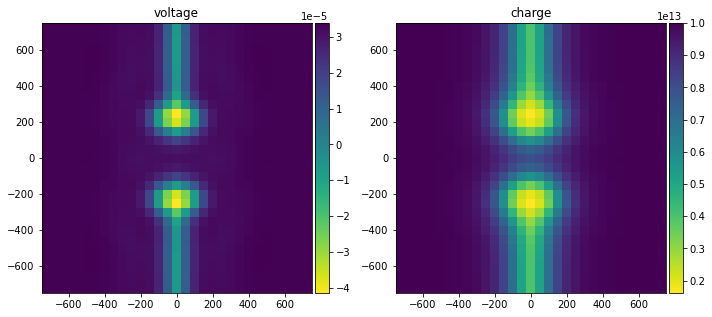

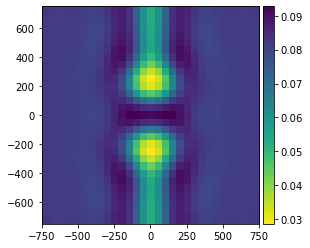

In [14]:
iteration = 3
coord_2D, voltage_2D = plotting_pes.data_cross_section(coord, voltage_vec[iteration], section=[None, None, 0])
coord_2D, charge_2D = plotting_pes.data_cross_section(coord, charge_vec[iteration], section=[None, None, 0])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plotting_pes.colormap(coord_2D, voltage_2D, aspect_equal=True, ax=ax1, title='voltage')
plotting_pes.colormap(coord_2D, charge_2D/cell_area, aspect_equal=True, ax=ax2, title='charge')

plt.tight_layout()
plt.show()

if iteration != 0:
    fig, ax = plt.subplots()
    coord_2D, ldos_2D = plotting_pes.data_cross_section(coord[ldos_vec[iteration].indices], 
                                                        [ldos_vec[iteration](energy=0)], section = [None, None, 0])
    plotting_pes.colormap(coord_2D, ldos_2D, ax=ax)
    plt.show()

In [21]:
zones = np.array([False, True, False, False, True, True, True])
w = 10
size = 10

p_geom2 = copy.deepcopy(p_geom)
p_geom.update({'L_reg' : p_geom['L_pes'], 
               'W_reg' : p_geom['W_pes'],
               'd0':25, 
               'd1' : 25, 
               'd2' : 65, 
                'zones' : zones, 
                'w' : w, 
                'size' : size})

pp_builder2 = make_pescado_system(**p_geom)
pp_problem2 = extension_pes.finalized(pp_builder2, parallelize='original')
coord = pp_problem2.mesh_inst.coordinates()

The interfaces are located at: 
 [-30.0, -5.0, 5.0, 30.0, 95.0, 105.0, 115.0, 125.0]
Info (ref point, grid size z direction):
 [[-10.   10. ]
 [ 10.    7.5]
 [ 35.   11. ]
 [100.   10. ]]
Zone tracker:
 [[0, 1], [2], [3], [4, 5, 6]]
Original pescado parallelization is used (no volume parallelization)
Finalizing mesh builder
0


C:\Users\helle\miniconda3\pkgs\pescado\pescado\mesher\mesh.py:786: UserWarning: Mesh continuity not tested. Change "validate_mesh" to true or use "validate_mesh_continuity" method to test it.
  'Mesh continuity not tested. Change "validate_mesh" to true '


Done
Constructing capacitance matrix
Done
Calculating volume took 28.579684019088745 seconds
Prepare LP
Done
Function finalized took 65.4138 seconds


In [22]:
kwant_builder2 = builder.make_kwant_system(**p_geom2)
kpm_builder2 = builder.make_kpm_system(**p_geom2)

conversion_index2 = pescado_kwant.conversion_index(
        pp_problem2, kwant_builder2, kpm_builder2, extra_dim=[2], 
        coord_extra_dim=[0])

# This creates a pk_problem and writes it to the geometry file
pk_problem2 = pescado_kwant.PescadoKwantProblem(
        poisson_problem = pp_problem2, 
        kwant_builder = kwant_builder2, 
        kpm_builder = kpm_builder2,
        conversion_unit = c.elementary_charge/p_geom2['t'], 
        conversion_index = conversion_index2,
        extra_dim = [2], 
        coord_extra_dim = [0])

(14457, 3) (961, 3)


In [23]:
voltage_vec2, charge_vec2, ldos_vec2 = pk_problem2.solve_fsc_nr(voltage = voltage,
                        charge_density = charge_density,
                        initial_potential = initial_potential,
                        num_moments=50,
                        iterations=5, 
                        params=params, 
                        center = np.array([0,0]))

Function exact_ldos took 0.2483 seconds
Iteration 2 took 1.0721323490142822 s
Iteration 3 took 1.0920803546905518 s
Iteration 4 took 1.0821068286895752 s
Iteration 5 took 1.085099458694458 s
Iteration 6 took 1.149925708770752 s
Function solve_sc_continuous took 7.3723 seconds
Function reduce_system took 0.4039 seconds
Function exact_ldos took 2.8235 seconds
Iteration 2 took 1.1658828258514404 s
Iteration 3 took 1.1838345527648926 s
Iteration 4 took 1.209766149520874 s
Iteration 5 took 1.1678764820098877 s
Function solve_sc_continuous took 7.1978 seconds
Function reduce_system took 0.3820 seconds
Function exact_ldos took 2.8195 seconds
Iteration 2 took 1.1678779125213623 s
Iteration 3 took 1.1529181003570557 s
Iteration 4 took 1.1319735050201416 s
Iteration 5 took 1.1469330787658691 s
Function solve_sc_continuous took 6.9624 seconds
Function reduce_system took 0.3301 seconds
Function exact_ldos took 2.6798 seconds
Iteration 2 took 1.2097671031951904 s
Iteration 3 took 1.5219318866729736

In [25]:
coord2 = pp_problem2.mesh_inst.coordinates()


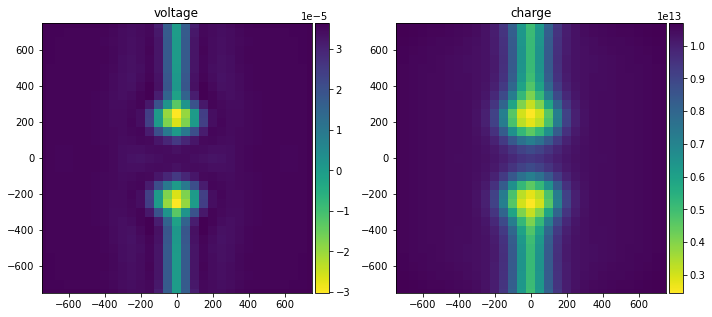

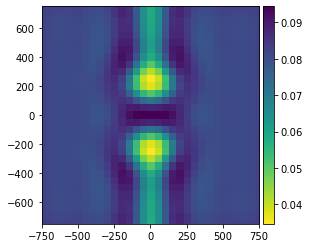

In [28]:
iteration = 3
coord_2D, voltage_2D = plotting_pes.data_cross_section(coord2, voltage_vec2[iteration], section=[None, None, 0])
coord_2D, charge_2D = plotting_pes.data_cross_section(coord2, charge_vec2[iteration], section=[None, None, 0])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plotting_pes.colormap(coord_2D, voltage_2D, aspect_equal=True, ax=ax1, title='voltage')
plotting_pes.colormap(coord_2D, charge_2D/cell_area, aspect_equal=True, ax=ax2, title='charge')

plt.tight_layout()
plt.show()

if iteration != 0:
    fig, ax = plt.subplots()
    coord_2D, ldos_2D = plotting_pes.data_cross_section(coord2[ldos_vec2[iteration].indices], 
                                                        [ldos_vec2[iteration](energy=0)], section = [None, None, 0])
    plotting_pes.colormap(coord_2D, ldos_2D, ax=ax)
    plt.show()

In [59]:
grid = [1,2]
L = 10
W = 10
lol_builder = builder._make_system(grid, L, W)

ValueError: Dimensionality of start position does not match the space dimensionality.

In [68]:
import kwant
# First, define the tight-binding system
sys = kwant.Builder()

# Here, we are only working with square lattices
# This only works for 3D, or 2D cross sections xz, yz
# Anyway, a 2D xy or 1D cross section is meaningless in this case
lat = kwant.lattice.Monatomic(np.diag(grid), norbs=1)

def scat_reg(pos):
    x,y = pos
    return -L/2 <= x <= L/2 and -W/2 <= y <= W/2

## On site hamiltonian
sys[lat.shape(scat_reg, (0,0))] = 3

## Hopping in x and y direction
sys[lat.neighbors(1)] = -1

In [55]:
sys[lat.shape(scat_reg, (0,0))] = 2

ValueError: Dimensionality of start position does not match the space dimensionality.

In [60]:
lat = kwant.lattice.Monatomic(np.diag(grid), norbs=1)


In [70]:
lat._prim_vecs

array([[1.0, 0.0],
       [0.0, 2.0]])

In [71]:
lat.prim_vecs

array([[1., 0.],
       [0., 2.]])

In [76]:
lat.dim

2